In [1]:
import numpy as np
import sep

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
from matplotlib import rcParams
from matplotlib.patches import Ellipse

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
hdul = fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
hdul.info()

Filename: jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D, D, D, D, 27A, D, D, 6A, 5A, 1A, 5A, 5A, 5A, L, 4A, K, 5A, 9A, D, D, D

In [4]:
data = hdul[1].data

In [5]:
data = np.nan_to_num(data)
data = data - np.min(data)
data = data / np.max(data)

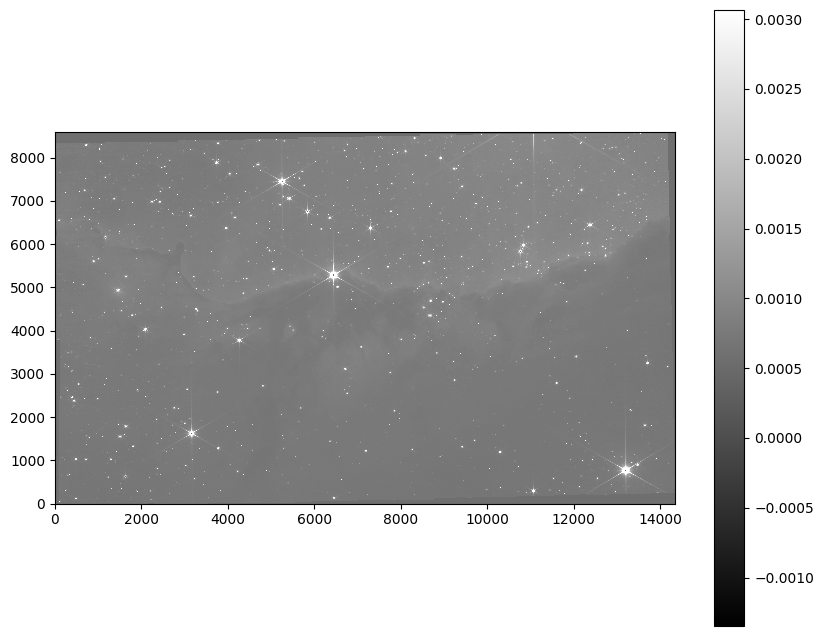

In [6]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("figure1.png", dpi=150)

In [7]:
bkg = sep.Background(data)

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0007818451267667115
1.1169798199262004e-05


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

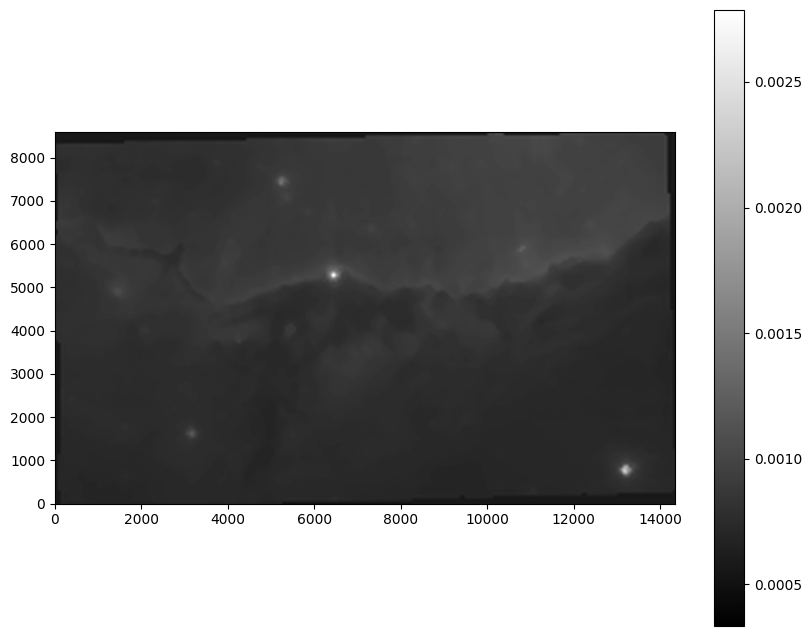

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("figure2.png", dpi=150)

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

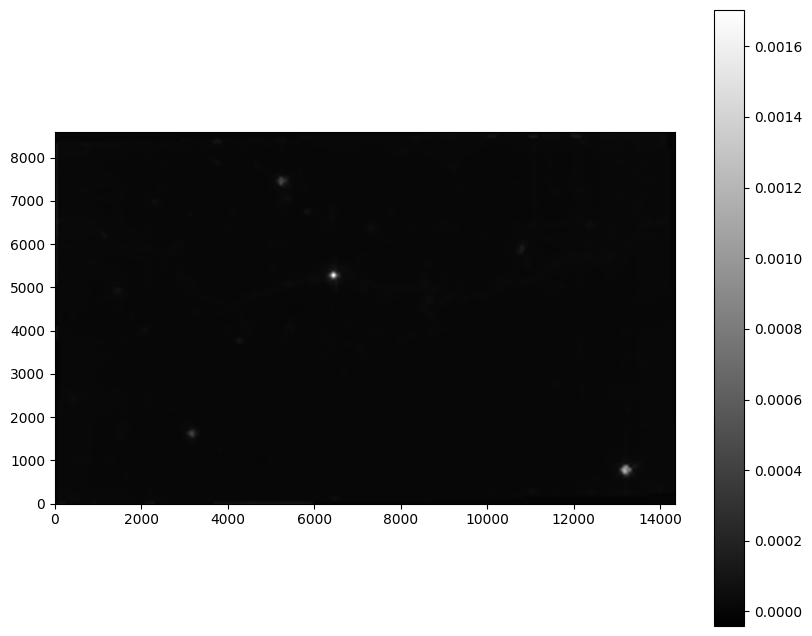

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("figure3.png", dpi=150)

In [13]:
# subtract the background
data_sub = data - bkg

In [14]:
sep.set_extract_pixstack(10000000)

In [15]:
objects = sep.extract(data_sub, 10000, err=bkg.globalrms)

In [16]:
# how many objects were detected
len(objects)

303

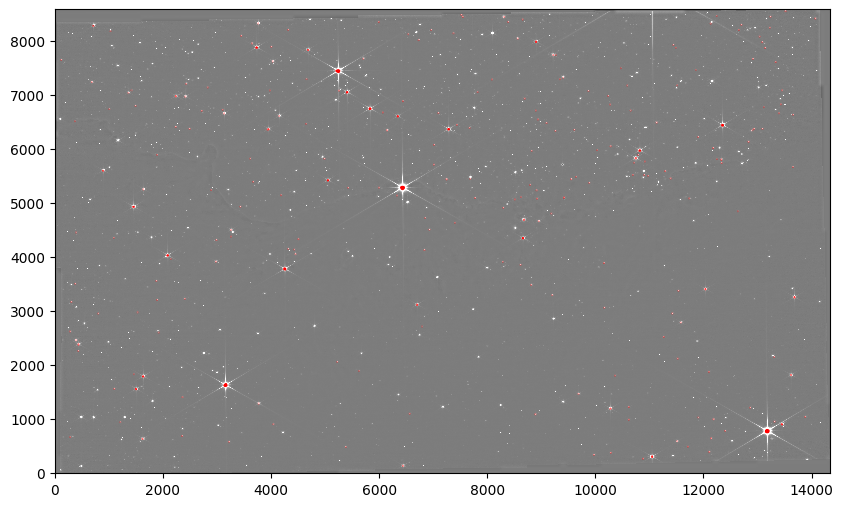

In [17]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("figure4.png", dpi=150)

In [ ]:
# available fields
objects.dtype.names

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [19]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2.867552 +/- 1.693385
object 1: flux = 3.270852 +/- 1.808550
object 2: flux = 3.010761 +/- 1.735154
object 3: flux = 3.110645 +/- 1.763702
object 4: flux = 2.930602 +/- 1.711900
object 5: flux = 2.934289 +/- 1.712977
object 6: flux = 2.781880 +/- 1.667897
object 7: flux = 4.001650 +/- 2.000412
object 8: flux = 2.268629 +/- 1.506197
object 9: flux = 2.495893 +/- 1.579840


Text(0.5, 1.0, 'Histogram of Fluxes')

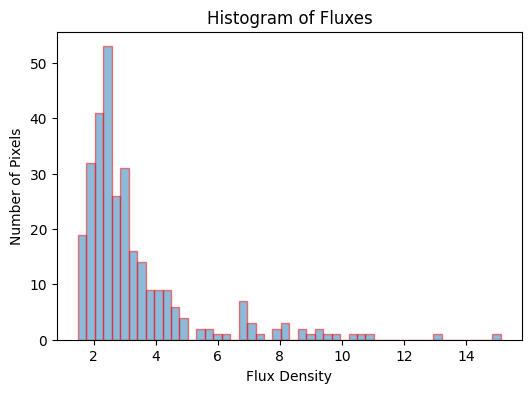

In [26]:
plt.figure(figsize=(6,4))
plt.hist(flux,bins=50,edgecolor="red",alpha=0.5)
plt.xlabel("Flux Density")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Fluxes")

In [21]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = "jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = "./jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits"
fname2 = "./jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits"
fname3 = "./jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits"
fname4 = "./jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits"
fname5 = "./jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits"

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567170 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654335564.228 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T11:43:37.007' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.631' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.557313 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654186065.609 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected ./jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits -> ./jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.326' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574431 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654445751.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected ./jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits -> ./jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]


Reprojected ./jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits -> ./jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]


Reprojected ./jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits -> ./jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T11:43:37.025' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.695' from MJD-END'. [astropy.wcs.wcs]


Reprojected ./jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> ./jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


In [22]:
# read image into standard 2-d numpy array
hdul = fits.open("jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits")
data1 = hdul[0].data
data1 = np.nan_to_num(data1)
data1 = data1 - np.min(data1)
data1 = data1 / np.max(data1)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits")
data2 = hdul[0].data
data2 = np.nan_to_num(data2)
data2 = data2 - np.min(data2)
data2 = data2 / np.max(data2)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits")
data3 = hdul[0].data
data3 = np.nan_to_num(data3)
data3 = data3 - np.min(data3)
data3 = data3 / np.max(data3)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits")
data4 = hdul[0].data
data4 = np.nan_to_num(data4)
data4 = data4 - np.min(data4)
data4 = data4 / np.max(data4)

hdul = fits.open("jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits")
data5 = hdul[0].data
data5 = np.nan_to_num(data5)
data5 = data5 - np.min(data5)
data5 = data5 / np.max(data5)

hdul = fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
data6 = hdul[1].data
data6 = np.nan_to_num(data6)
data6 = data6 - np.min(data6)
data6 = data6 / np.max(data6)

[[0.00096879 0.00096879 0.00096879 ... 0.00096879 0.00096879 0.00096879]
 [0.00096879 0.00096879 0.00096879 ... 0.00096879 0.00096879 0.00096879]
 [0.00096879 0.00096879 0.00096879 ... 0.00096879 0.00096879 0.00096879]
 ...
 [0.00096879 0.00096879 0.00096879 ... 0.00096879 0.00096879 0.00096879]
 [0.00096879 0.00096879 0.00096879 ... 0.00096879 0.00096879 0.00096879]
 [0.00096879 0.00096879 0.00096879 ... 0.00096879 0.00096879 0.00096879]]


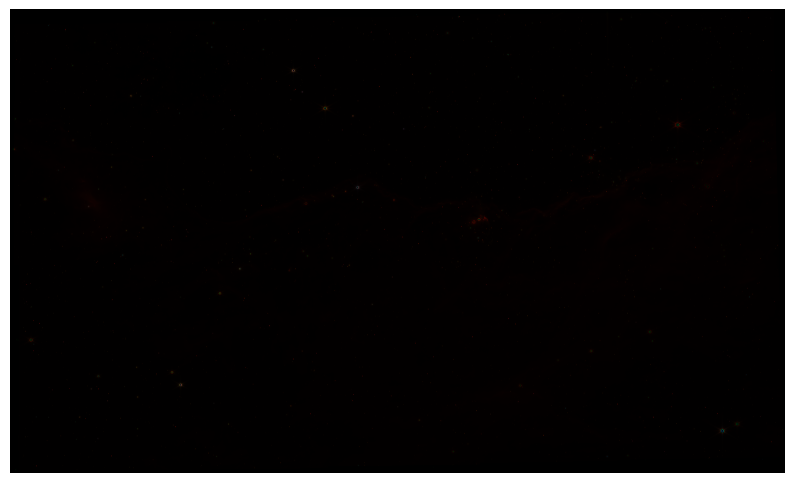

In [ ]:
r = np.clip(data4 + 0.5 * data3, 0, 1)
g = np.clip(data2 + 0.5 * data5, 0, 1)
b = np.clip(data6 + 0.5 * data1, 0, 1)
print(r)
rgb = np.stack([r,g,b], axis = -1)

#Display the plot and save
plt.figure(figsize=(10,10))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.axis()
plt.savefig("ngc3324_false_color.png", dpi = 300, bbox_inches='tight')
plt.show()